Copyright (c) 2015, 2016 [Sebastian Raschka](sebastianraschka.com)
<br>
[Li-Yi Wei](http://liyiwei.org/)

https://github.com/1iyiwei/pyml

[MIT License](https://github.com/1iyiwei/pyml/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 10 - Predicting Continuous Target Variables with Regression Analysis

We talk only about classification so far

Regression is also important

## Classification versus regression

Classification: discrete output
<img src='./images/01_03.png'>

Regression: continuous output
<img src='./images/01_04.png' width=50%>

Both are supervised learning
* require target variables

More similar than they appear
* similar principles, e.g. optimization
* similar goals, e.g. linear decision boundary for classification versus line fitting for regression


Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,pandas,matplotlib,sklearn,seaborn

last updated: 2016-09-19 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
sklearn 0.17.1
seaborn 0.7.1


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

### Overview

- [Introducing a simple linear regression model](#Introducing-a-simple-linear-regression-model)
- [Exploring the Housing Dataset](#Exploring-the-Housing-Dataset)
  - [Visualizing the important characteristics of a dataset](#Visualizing-the-important-characteristics-of-a-dataset)
- [Implementing an ordinary least squares linear regression model](#Implementing-an-ordinary-least-squares-linear-regression-model)
  - [Solving regression for regression parameters with gradient descent](#Solving-regression-for-regression-parameters-with-gradient-descent)
  - [Estimating the coefficient of a regression model via scikit-learn](#Estimating-the-coefficient-of-a-regression-model-via-scikit-learn)
- [Fitting a robust regression model using RANSAC](#Fitting-a-robust-regression-model-using-RANSAC)
- [Evaluating the performance of linear regression models](#Evaluating-the-performance-of-linear-regression-models)
- [Using regularized methods for regression](#Using-regularized-methods-for-regression)
- [Turning a linear regression model into a curve - polynomial regression](#Turning-a-linear-regression-model-into-a-curve---polynomial-regression)
  - [Modeling nonlinear relationships in the Housing Dataset](#Modeling-nonlinear-relationships-in-the-Housing-Dataset)
  - [Dealing with nonlinear relationships using random forests](#Dealing-with-nonlinear-relationships-using-random-forests)
    - [Decision tree regression](#Decision-tree-regression)
    - [Random forest regression](#Random-forest-regression)
- [Summary](#Summary)

In [2]:
from IPython.display import Image

%matplotlib inline

# Introducing a simple linear regression model

Model:
$
y = \sum_{i=0}^n w_i x_i = \mathbf{w}^T \mathbf{x}
$
with $x_0 = 1$.

Given a collection of sample data $\{\mathbf{x^{(i)}}, y^{(i)} \}$, find the line $\mathbf{w}$ that minimizes the regression error:
$$
\begin{align}
L(X, Y, \mathbf{w}) 
= \sum_i \left( y^{(i)} - \hat{y}^{(i)} \right)^2 
= \sum_i \left( y^{(i)} - \mathbf{w}^T \mathbf{x}^{(i)} \right)^2
\end{align}
$$

## 2D case

$
y = w_0 + w_1 x
$

<img src='./images/10_01.png' width=90%> 

# General regression models

We can fit different analytic models/functions (not just linear ones) to a given dataset.

Start a linear one with a real-data set first
* easier to understand and interpret (e.g. positive/negative correlation) 
* less prone for over-fitting 

Followed by non-linear models

# Exploring the Housing dataset

Let's explore a realistic problem: predicting house prices based on their features.

This is a regression problem
* house prices are continuous variables not discrete categories

Source: [https://archive.ics.uci.edu/ml/datasets/Housing](https://archive.ics.uci.edu/ml/datasets/Housing)

Boston suburbs

Attributes (1-13) and target (14):
    
<pre>
1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per $10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in $1000's
</pre>

## Read the dataset

In [3]:
import pandas as pd

# online dataset
data_src = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
# local dataset
data_src = '../datasets/housing/housing.data'

df = pd.read_csv(data_src,
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


<hr>

### Note:


If the link to the Housing dataset provided above does not work for you, you can find a local copy in this repository at [./../datasets/housing/housing.data](./../datasets/housing/housing.data).

Or you could fetch it via

In [4]:
if False:
    df = pd.read_csv('https://raw.githubusercontent.com/1iyiwei/pyml/master/code/datasets/housing/housing.data',
                      header=None, sep='\s+')

    df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
                  'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
                  'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
    df.head()

## Visualizing the important characteristics of a dataset

Use scatter plots to visualize the correlations between pairs of features.

In the seaborn library below, the diagonal lines are histograms for single features.

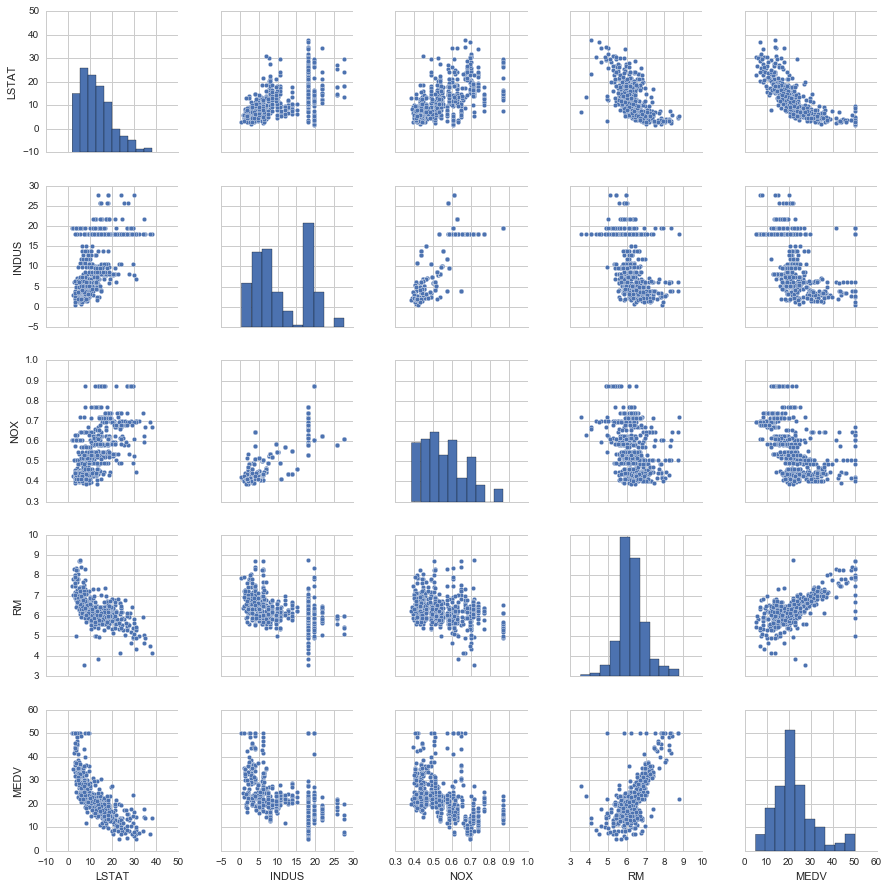

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
# plt.savefig('./figures/scatter.png', dpi=300)
plt.show()

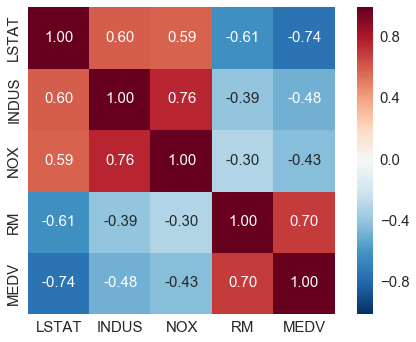

In [6]:
import numpy as np


cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

# plt.tight_layout()
# plt.savefig('./figures/corr_mat.png', dpi=300)
plt.show()

In [7]:
sns.reset_orig()
%matplotlib inline

# Implementing an ordinary least squares linear regression model

## Solving regression for regression parameters with gradient descent

In [8]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [9]:
X = df[['RM']].values
y = df['MEDV'].values

In [10]:
from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
#y_std = sc_y.fit_transform(y) # deprecation warning
y_std = sc_y.fit_transform(y.reshape(-1, 1)).ravel()

In [11]:
lr = LinearRegressionGD()
_ = lr.fit(X_std, y_std)

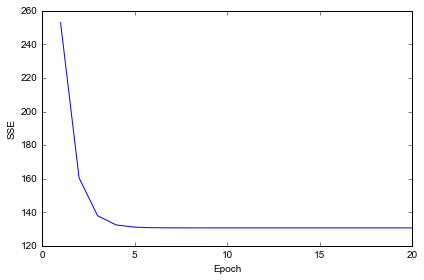

In [12]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()
# plt.savefig('./figures/cost.png', dpi=300)
plt.show()

In [13]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='lightblue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)    
    return 

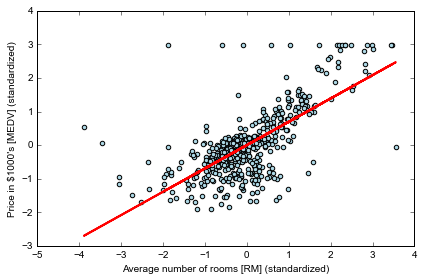

In [14]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.tight_layout()
# plt.savefig('./figures/gradient_fit.png', dpi=300)
plt.show()

In [15]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


In [16]:
num_rooms_std = sc_x.transform([[5.0]]) 
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


## Estimating the coefficient of a regression model via scikit-learn

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


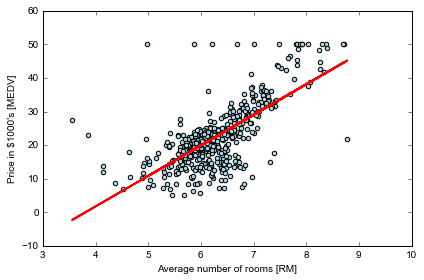

In [19]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()
# plt.savefig('./figures/scikit_lr_fit.png', dpi=300)
plt.show()

**Normal Equations** alternative for direct analytic computing without any iteration:

In [20]:
# adding a column vector of "ones"
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print('Slope: %.3f' % w[1])
print('Intercept: %.3f' % w[0])

Slope: 9.102
Intercept: -34.671


# Fitting a robust regression model using RANSAC

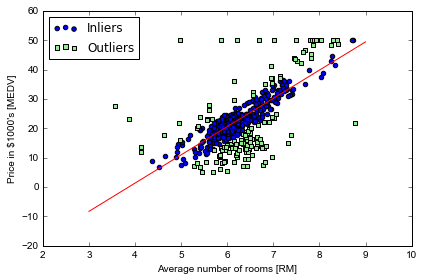

In [21]:
from sklearn.linear_model import RANSACRegressor


ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         residual_metric=lambda dy: np.sum(np.abs(dy), axis=1), 
                         residual_threshold=5.0, 
                         random_state=0)
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/ransac_fit.png', dpi=300)
plt.show()

In [22]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 9.621
Intercept: -37.137


# Evaluating the performance of linear regression models

In [23]:
from sklearn.cross_validation import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [24]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

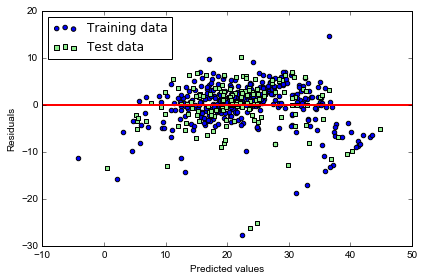

In [25]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

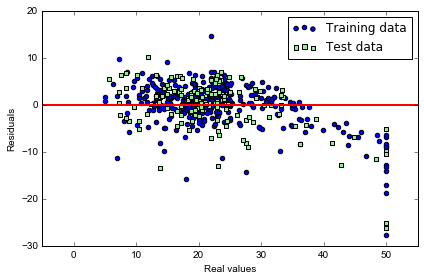

In [26]:
plt.scatter(y_train,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Real values')
plt.ylabel('Residuals')
plt.legend(loc='best')
plt.hlines(y=0, xmin=-5, xmax=55, lw=2, color='red')
plt.xlim([-5, 55])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

In [27]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


# Using regularized methods for regression

In [28]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[-0.11311792  0.04725111 -0.03992527  0.96478874 -0.          3.72289616
 -0.02143106 -1.23370405  0.20469    -0.0129439  -0.85269025  0.00795847
 -0.52392362]


In [29]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 20.926, test: 28.876
R^2 train: 0.753, test: 0.653


# Turning a linear regression model into a curve - polynomial regression

In [30]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [31]:
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2) # e.g. from [a, b] to [1, a, b, a*a, a*b, b*b]
X_quad = quadratic.fit_transform(X)

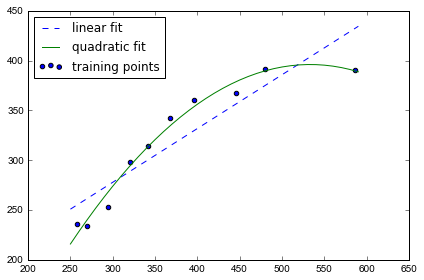

In [32]:
# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/poly_example.png', dpi=300)
plt.show()

In [33]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [34]:
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


## Modeling nonlinear relationships in the Housing Dataset

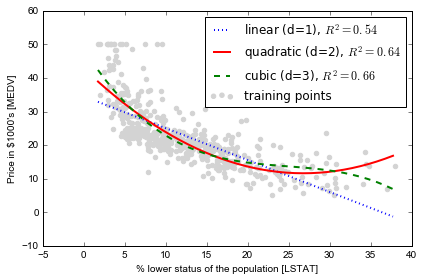

In [35]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('./figures/polyhouse_example.png', dpi=300)
plt.show()

Transforming the dataset from observation:

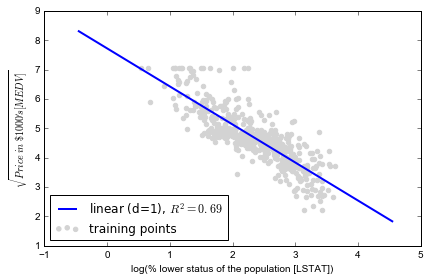

In [36]:
X = df[['LSTAT']].values
y = df['MEDV'].values

# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# training
regr = regr.fit(X_log, y_sqrt)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]
y_lin_fit = regr.predict(X_fit)

# plot results
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')

plt.tight_layout()
# plt.savefig('./figures/transform_example.png', dpi=300)
plt.show()

# Dealing with nonlinear relationships using random forests

Previously we have used decision trees for classification.
They can also be used for regression.
In classification, we associate a class label for each leaf node.
In regression, we fit a function for each leaf node.
In the simplest case, the function is a constant, which will be the mean of all y values within that node if the loss function is based on MSE.
In this case, the whole tree essentially fits a piecewise constant function to the training data.

Similar to building a decision tree for classification, a decision tree for regression can be built by iteratively splitting each node based on optimizing an objective function, such as MSE mentioned above.
Specifically,
$$IG(D_p) = I(D_p) - \sum_{j=1}^m \frac{N_j}{N_p} I(D_j)$$
, where $IG$ is the information gain we try to maximize for splitting each parent node $p$ with dataset $D_p$, $I$ is the information measure for a given dataset, and $N_p$ and $N_j$ are the number of data vectors within each parent and child nodes.
$m = 2$ for the usual binary split.
For MSE, we have
$$I(D) = \sum_{i \in D} \left|y^{(i)} - \mu_D \right|^2$$
, where $\mu_D$ is the mean of the target $y$ values of the dataset $D$.

## Decision tree regression

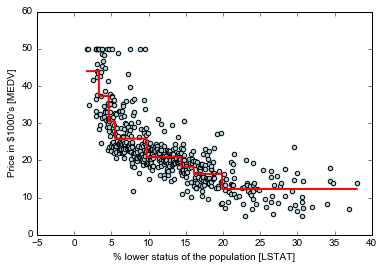

In [37]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
# plt.savefig('./figures/tree_regression.png', dpi=300)
plt.show()

## Random forest regression

In [38]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

In [39]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


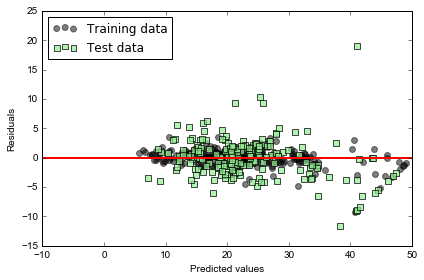

In [40]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='black', 
            marker='o', 
            s=35,
            alpha=0.5,
            label='Training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='lightgreen', 
            marker='s', 
            s=35,
            alpha=0.7,
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

# Summary

# Reading

* PMY Chapter 10